In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import keras
#from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
import keras.backend as K

import tensorflow as tf

import os
import pickle
import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# Provide the path here
os.chdir('/Users/ianlo/Documents/Data Analyitcs & Data Science/Deep Learning Developer Course/minichallenge01/')

Using TensorFlow backend.


In [2]:
print(keras.__version__)
print(tf.__version__)

2.0.8
1.3.0


In [3]:
# example_per_class = 10000

# classes = ['airplane','alarm clock','ambulance','angel','ant','anvil','apple','axe','banana','bandage','barn',
#            'baseball bat','baseball','basket','basketball','bathtub','beach','bear','beard','bed','bee','belt',
#            'bicycle','binoculars','birthday cake','blueberry','book','boomerang','bottlecap','bowtie','bracelet',
#            'brain','bread','broom','bulldozer','bus','bush','butterfly','cactus','cake','calculator','calendar',
#            'camel','camera','campfire','candle','cannon','canoe','car','carrot','cello','computer','cat',
#            'chandelier','clock','cloud','coffee cup','compass','cookie','couch','cow','crab','crayon','crocodile',
#            'crown','cup','diamond','dog','dolphin','donut','dragon','dresser','drill','drums','duck','dumbbell',
#            'ear','elbow','elephant','envelope','eraser','eye','eyeglasses','face','fan','feather','fence','finger',
#            'fire hydrant','fireplace','firetruck','fish','flamingo','flashlight','flip flops','floor lamp',
#            'flower','flying saucer','foot','fork']

# example_per_class = 5000

# classes = ['airplane','alarm clock','ambulance','angel','ant','anvil','apple','axe',
#            'banana','bandage','barn','baseball bat','baseball','basket',
#            'basketball','bathtub','beach','bear','beard','bed','bee','belt',
#            'bicycle','binoculars','birthday cake','blueberry',
#            'book','boomerang','bottlecap','bowtie','bracelet','brain',
#            'bread','broom','bulldozer','bus','bush','butterfly','cactus','cake']

example_per_class = 2000

classes = ['airplane','alarm clock','ambulance','angel','ant','anvil','apple','axe',
           'banana','bandage','barn','baseball bat','baseball','basket',
           'basketball','bathtub','beach','bear','beard','bed','bee','belt',
           'bicycle','binoculars','birthday cake','blueberry',
           'book','boomerang','bottlecap','bowtie','bracelet','brain',
           'bread','broom','bulldozer','bus','bush','butterfly','cactus','cake']

len(classes)

40

In [4]:
# #This cell is only if you are loading the data from scratch
# # get the data 
# quickdraws = [np.load("../../data/{}.npy".format(qdraw))[:num_examples_per_class] for qdraw in classes]

# # Concat the arrays together
# x_data = np.concatenate(quickdraws,axis=0)

# x_data.shape

### Load the data set from npy file

In [5]:
#x_data = pd.DataFrame(np.load("./x_data_100_classes_10k.npy"))
#x_data = np.load("./x_data_40_classes_5k.npy")
x_data = np.load("./x_data_40_classes_2k.npy")

x_data.shape

(80000, 784)

The x_data is a 28 x 28 matrix flattened into a single row per image. There is no labels so we need to create the labels. Assuming that each 10,000 block belongs to 1 class

In [6]:
#x_data.head(5)
#x_data = x_data.as_matrix

In [7]:
labels = [np.full((example_per_class,), classes.index(qdraw)) for qdraw in classes]

## Concat the arrays together
y_data = np.concatenate(labels,axis=0)
y_data.shape

(80000,)

Displaying the objects

In [8]:
def show_object(obj):
    # Reshape 784 array into 28x28 image
    image = obj.reshape([28,28])
    fig, axes = plt.subplots(1, )
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    plt.imshow(image, cmap='gray_r')
    plt.show()

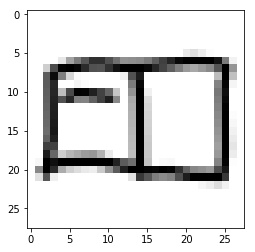

book


In [9]:
show_object(x_data[53000])
# the y_data starts at 0 hence index 5 is actually anvil
print(classes[y_data[53000]])

In [10]:
print(x_data.shape)
print(y_data.shape)

(80000, 784)
(80000,)


Shuffling the data to ensure that the training is done across the different classes randomly

In [15]:
#shuffling function
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [16]:
x_data, y_data = unison_shuffled_copies(x_data, y_data)

In [17]:
print(classes[y_data[0]])
#y_data[0]

binoculars


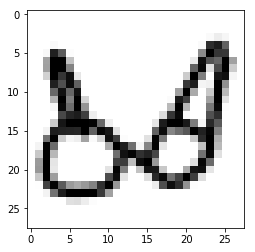

In [18]:
show_object(x_data[0])

### Create train and test set

In [19]:
# train test split based on random sampling
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.15, random_state=42)

In [20]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(68000, 784)
(68000,)
(12000, 784)
(12000,)


### Model parameters

In [21]:
batch_size = 64
num_classes = len(classes)
epochs = 50
data_augmentation = True
#num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'quickdraw_CNN.h5'

Convert class vectors to binary class matrices

In [22]:
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Normalise the input vectors

In [23]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [24]:
x_train = x_train.reshape([x_train.shape[0],28,28,1])
x_train.shape

(68000, 28, 28, 1)

In [25]:
x_test = x_test.reshape([x_test.shape[0],28,28,1])
x_test.shape

(12000, 28, 28, 1)

### Building the model

In [33]:
#Inp = Input(shape=(28,28,3),name = 'Input_layer')
Inp = Input(shape=(28,28,1),name = 'Input_layer')

#ConvBlock 01
conv01 = Conv2D(32, (3, 3), padding='same',activation = 'relu', input_shape=Inp.shape,name = 'Conv01_layer')(Inp)
conv02 = Conv2D(32, (3, 3),activation = 'relu',name = 'Conv02_layer')(conv01)
maxpool_01 = MaxPooling2D(pool_size=(2, 2),name = 'MaxPool01_layer')(conv02)
drop01 = Dropout(0.25,name = 'Dropout01_layer')(maxpool_01)

#Convblock 02
conv03 = Conv2D(64, (3, 3), padding='same',activation = 'relu',name = 'Conv03_layer')(drop01)
conv04 = Conv2D(64, (3, 3),activation = 'relu',name = 'Conv04_layer')(conv03)
maxpool_02 = MaxPooling2D(pool_size=(2, 2),name = 'MaxPool02_layer')(conv04)
drop02 = Dropout(0.25,name = 'Dropout02_layer')(maxpool_02)

#Convblock 03
conv05 = Conv2D(128, (3, 3), padding='same',activation = 'relu',name = 'Conv05_layer')(drop02)
conv06 = Conv2D(128, (3, 3),activation = 'relu',name = 'Conv06_layer')(conv05)
maxpool_03 = MaxPooling2D(pool_size=(2, 2),name = 'MaxPool03_layer')(conv06)
drop03 = Dropout(0.25,name = 'Dropout03_layer')(maxpool_03)

# Fully Connected Dense block
x = Flatten(name = 'Flatten_layer')(drop03)
x = Dense(1024, activation='relu',name = 'Dense01_layer')(x)
x = Dense(512, activation='relu',name = 'Dense02_layer')(x)
x = Dropout(0.2,name = 'Dropout04_layer')(x)
logits_layer = Dense(num_classes, name= 'logits_layer')(x)
output = Activation('softmax',name = 'Sofftmax_layer')(logits_layer)

In [34]:
# Define model inputs and output
model = Model(Inp, output)

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     (None, 28, 28, 1)         0         
_________________________________________________________________
Conv01_layer (Conv2D)        (None, 28, 28, 32)        320       
_________________________________________________________________
Conv02_layer (Conv2D)        (None, 26, 26, 32)        9248      
_________________________________________________________________
MaxPool01_layer (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
Dropout01_layer (Dropout)    (None, 13, 13, 32)        0         
_________________________________________________________________
Conv03_layer (Conv2D)        (None, 13, 13, 64)        18496     
_________________________________________________________________
Conv04_layer (Conv2D)        (None, 11, 11, 64)        36928     
__________

Configure model parameters

In [36]:
# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [37]:
print('Using real-time data augmentation.')
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

Using real-time data augmentation.


In [38]:
# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

In [39]:
# Fit the model on the batches generated by datagen.flow().
hist = model.fit_generator(datagen.flow(x_train, y_train,
                                 batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    workers=4)

Epoch 1/50
1062/1062 [==============================] - 258s - loss: 3.2164 - acc: 0.1326 - val_loss: 2.5857 - val_acc: 0.2920
Epoch 2/50
1062/1062 [==============================] - 284s - loss: 2.6624 - acc: 0.2684 - val_loss: 2.1304 - val_acc: 0.4191
Epoch 3/50
1062/1062 [==============================] - 287s - loss: 2.3681 - acc: 0.3486 - val_loss: 1.8751 - val_acc: 0.4767
Epoch 4/50
1062/1062 [==============================] - 271s - loss: 2.1566 - acc: 0.4004 - val_loss: 1.6576 - val_acc: 0.5337
Epoch 5/50
1062/1062 [==============================] - 272s - loss: 2.0076 - acc: 0.4402 - val_loss: 1.5083 - val_acc: 0.5782
Epoch 6/50
1062/1062 [==============================] - 284s - loss: 1.8884 - acc: 0.4731 - val_loss: 1.4346 - val_acc: 0.5948
Epoch 7/50
1062/1062 [==============================] - 263s - loss: 1.8008 - acc: 0.4963 - val_loss: 1.3301 - val_acc: 0.6242
Epoch 8/50
1062/1062 [==============================] - 257s - loss: 1.7227 - acc: 0.5175 - val_loss: 1.2632 - 

In [40]:
def plot_train(hist):
    h = hist.history
    if 'acc' in h:
        meas='acc'
        loc='lower right'
    else:
        meas='loss'
        loc='upper right'
    plt.plot(hist.history[meas])
    plt.plot(hist.history['val_'+meas])
    plt.title('model '+meas)
    plt.ylabel(meas)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc=loc)
    

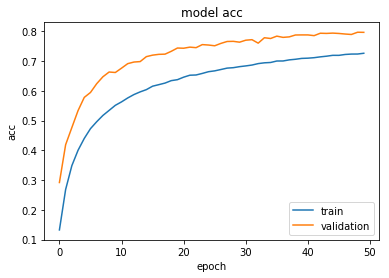

In [41]:
plot_train(hist)

### Evaluate the model

In [48]:
#Evaluate model with test data set and share sample prediction results
# evaluation = model.evaluate_generator(datagen.flow(x_test, y_test,
#                                                    batch_size=batch_size,
#                                                    shuffle=False),
#                                       steps=x_test.shape[0] // batch_size,
#                                       workers=4)

evaluation = model.evaluate(x_test, y_test, batch_size=batch_size)
print('Model Accuracy = %.2f' % (evaluation[1]))
print('Model Loss = %.2f' % (evaluation[0]))

x_test.shape
y_test.shape

11968/12000 [============================>.] - ETA: 0sModel Accuracy = 0.80
Model Loss = 0.73


(12000, 40)

### Make predictions

In [ ]:
preds = model.predict(x_test)

In [ ]:
for predict_index, predicted_y in enumerate(preds):
    actual_label = classes[np.argmax(y_test[predict_index])]
    predicted_label = classes[np.argmax(predicted_y)]
    print('Actual Label = %s vs. Predicted Label = %s' % (actual_label,
                                                          predicted_label))
    if predict_index == predicted_y.shape[0]:
        break